In [3]:
import pandas as pd

In [91]:
data = pd.read_csv("data/data_unclean.csv")

In [92]:
data.head()

,id,exercise_name,type_of_activity,type_of_equipment,body_part,type,muscle_groups_activated,instructions
0,0,Push-Ups,Strength,Bodyweight,Upper Body,Push,"Pectorals, Triceps, Deltoids",Start in a high plank position with your hands...
1,1,Squats,Strength,Bodyweight,Lower Body,Push,"Quadriceps, Glutes, Hamstrings",Stand with feet shoulder-width apart. Lower yo...
2,2,Plank,Strength/Mobility,Bodyweight,Core,Hold,"Rectus Abdominis, Transverse Abdominis",Start in a forearm plank position with your el...
3,3,Deadlift,Strength,Barbell,Lower Body,Pull,"Glutes, Hamstrings, Lower Back","Stand with feet hip-width apart, barbell in fr..."
4,4,Bicep Curls,Strength,Dumbbells,Upper Body,Pull,"Biceps, Forearms","Stand with a dumbbell in each hand, arms fully..."


In [93]:
data.insert(0, "id", data.index)

ValueError: cannot insert id, already exists

In [77]:
data = data.drop_duplicates(subset=["Exercise Name"])

In [95]:
data.to_csv("data/data.csv", index=False)

In [22]:
## Starting dataset

In [96]:
df = pd.read_csv("data/data.csv")

In [82]:
df.columns.str.lower().str.replace(" ","_")

Index(['id', 'exercise_name', 'type_of_activity', 'type_of_equipment',
       'body_part', 'type', 'muscle_groups_activated', 'instructions'],
      dtype='object')

In [83]:
df.columns = df.columns.str.lower().str.replace(" ","_")

In [98]:
df.to_csv("data/data_unclean.csv", index=False)

## Index data to min_search

## Ingestion

In [40]:
df = pd.read_csv("data/data_unclean.csv")

In [25]:
df

,id,exercise_name,type_of_activity,type_of_equipment,body_part,type,muscle_groups_activated,instructions
0,0,Push-Ups,Strength,Bodyweight,Upper Body,Push,"Pectorals, Triceps, Deltoids",Start in a high plank position with your hands...
1,1,Squats,Strength,Bodyweight,Lower Body,Push,"Quadriceps, Glutes, Hamstrings",Stand with feet shoulder-width apart. Lower yo...
2,2,Plank,Strength/Mobility,Bodyweight,Core,Hold,"Rectus Abdominis, Transverse Abdominis",Start in a forearm plank position with your el...
3,3,Deadlift,Strength,Barbell,Lower Body,Pull,"Glutes, Hamstrings, Lower Back","Stand with feet hip-width apart, barbell in fr..."
4,4,Bicep Curls,Strength,Dumbbells,Upper Body,Pull,"Biceps, Forearms","Stand with a dumbbell in each hand, arms fully..."
...,...,...,...,...,...,...,...,...
202,204,Incline Dumbbell Row,Strength,Dumbbells,Upper Body,Pull,"Latissimus Dorsi, Biceps",Lie face down on an incline bench with a dumbb...
203,205,Machine Lat Pulldown,Strength,Machine,Upper Body,Pull,"Latissimus Dorsi, Biceps",Sit at a lat pulldown machine with a wide grip...
204,206,One-Arm Cable Row,Strength,Cable Machine,Upper Body,Pull,"Latissimus Dorsi, Biceps",Stand facing a cable machine with the handle a...
205,207,Face Pull,Strength,Cable Machine,Upper Body,Pull,"Rear Deltoids, Trapezius, Rhomboids",Attach a rope handle to a high cable pulley. P...


In [41]:
documents = df.to_dict(orient="records")

In [42]:
from minsearch import Index

In [43]:
index = Index(
    text_fields=['exercise_name','type_of_activity', 'body_part','type', 'muscle_groups_activated', 'instructions'],
    keyword_fields=[""]
)
index.fit(documents)

## Rag flow

In [44]:
query = "Give me leg excercises for hamstring"
results = index.search(query, num_results=10)

In [35]:
from mistralai import Mistral
import os

model = "mistral-medium-latest"

mistral_client = Mistral(api_key="AiR6nVk3c7AqRoZDicoCWoZ15IAu505g")

In [50]:
def search(query):

    boost_dict = {"question": 3, "text": 1, "section": 1}
    results = index.search(query, boost_dict=boost_dict, num_results=10)

    return results

In [45]:
prompt_template = """
You're a fitness instructor. Answer the QUESTION based on the CONTEXT from our exercises database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

entry_template = """
exercise_name: {exercise_name}
type_of_activity: {type_of_activity}
type_of_equipment: {type_of_equipment}
body_part: {body_part}
type: {type}
muscle_groups_activated: {muscle_groups_activated}
instructions: {instructions}
""".strip()

def build_prompts(query, search_results):    
    context = ""
    
    for doc in search_results:
        context += entry_template.format(**doc) + "\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()

    return prompt

In [46]:
def llm(prompt):
    response = mistral_client.chat.complete(
        model=model,
        messages=[
                {
                    "role":"user",
                    "content":prompt
                }
            ]
    )

    return response.choices[0].message.content

In [51]:

def rag(query):   
    results = search(query)
    prompt = build_prompts(query, results)
    answer = llm(prompt)

    return answer

In [52]:
query = "I want some core excercises that also helps my back"
ans = rag(query)

In [117]:
print(ans)

Here are the **core exercises** from the database that also **help strengthen your back** (specifically the lower back):

1. **Superman Exercise**
   - **Muscles Worked:** Lower Back, Glutes, Hamstrings
   - **Instructions:** Lie face down on the floor with arms extended. Lift your arms, chest, and legs off the ground simultaneously, then lower them back down.

2. **Dead Bug**
   - **Muscles Worked:** Rectus Abdominis, Hip Flexors (also engages the lower back for stability)
   - **Instructions:** Lie on your back with arms extended towards the ceiling. Lower opposite arm and leg towards the floor while keeping your back flat.

3. **Side Plank with Leg Lift**
   - **Muscles Worked:** Obliques, Glutes, Shoulders (glutes and lower back assist in stabilization)
   - **Instructions:** In a side plank position, lift your top leg towards the ceiling, then lower it back down.

For **direct lower back engagement**, the **Superman Exercise** is the best choice, while the **Dead Bug** and **Side 

## Retrival Evaluation

In [28]:
import pandas as pd

In [29]:
from tqdm.auto import tqdm

In [30]:
df_question = pd.read_csv('data/ground-truth-retrieval.csv')

In [31]:
ground_truth = df_question.to_dict(orient='records')

In [8]:
ground_truth[0]

{'id': 0, 'question': 'What is the starting position for doing push-ups?'}

In [20]:
def search(query):

    boost = {}
    results = index.search(query, boost_dict=boost, num_results=10)

    return results

In [10]:
def hit_rate(relevance_total):

    counter = 0
    for line in relevance_total:
        if True in line:
            counter += 1

    return counter / len(relevance_total)


In [11]:
def mrr(relevance_total):
    result = 0

    for line in relevance_total:
        for index, value in enumerate(line):
            if value == True:
                result += 1 / (index+1)
    return result / len(relevance_total)

In [12]:
def evaluate(ground_truth, search_function):

    relevance_total = []
    
    for q in tqdm(ground_truth):
        doc_id = q["id"]
        results = search_function(q)
        relevance = [res["id"]==doc_id for res in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [141]:
evaluate(ground_truth, lambda q: search(q["question"]))

  0%|          | 0/1035 [00:00<?, ?it/s]

{'hit_rate': 0.851207729468599, 'mrr': 0.7854543363239016}

## Finding the best parameters

In [1]:
! pip install hyperopt

  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 882.6 kB/s eta 0:00:02
   ------------------- -------------------- 0.8/1.6 MB 1.1 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 1.8 MB/s eta 0:00:00
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)


In [13]:
df_validation = df_question[:100]
df_test = df_question[100:]

In [15]:
import random

In [21]:
def simple_optimize(param_ranges, objective_function, n_iterations=10):
    best_params = None
    best_score = float('-inf')  # Assuming we're minimizing. Use float('-inf') if maximizing.

    for _ in range(n_iterations):
        # Generate random parameters
        current_params = {}
        for param, (min_val, max_val) in param_ranges.items():
            if isinstance(min_val, int) and isinstance(max_val, int):
                current_params[param] = random.randint(min_val, max_val)
            else:
                current_params[param] = random.uniform(min_val, max_val)
        
        # Evaluate the objective function
        current_score = objective_function(current_params)
        
        # Update best if current is better
        if current_score > best_score:  # Change to > if maximizing
            best_score = current_score
            best_params = current_params
    
    return best_params, best_score

In [22]:
gt_val = df_validation.to_dict(orient='records')

In [23]:
def minsearch_search(query, boost=None):
    if boost is None:
        boost = {}

    results = index.search(
        query=query,
        filter_dict={},
        boost_dict=boost,
        num_results=10
    )

    return results

In [29]:
param_ranges = {
    'exercise_name': (0.0, 3.0),
    'type_of_activity': (0.0, 3.0),
    'type_of_equipment': (0.0, 3.0),
    'body_part': (0.0, 3.0),
    'type': (0.0, 3.0),
    'muscle_groups_activated': (0.0, 3.0),
    'instructions': (0.0, 3.0),
}

def objective(boost_params):
    def search_function(q):
        return minsearch_search(q['question'], boost_params)

    results = evaluate(gt_val, search_function)
    return results['mrr']

In [30]:
simple_optimize(param_ranges, objective, n_iterations=20)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'exercise_name': 2.1112895370640152,
  'type_of_activity': 1.706103401522133,
  'type_of_equipment': 2.9792901301416492,
  'body_part': 0.45459132186539497,
  'type': 2.079470739358913,
  'muscle_groups_activated': 2.0882044319589674,
  'instructions': 0.7365698265619917},
 0.8678333333333333)

In [31]:
def minsearch_improved(query):
    boost = {
        'exercise_name': 2.11,
        'type_of_activity': 1.46,
        'type_of_equipment': 0.65,
        'body_part': 2.65,
        'type': 1.31,
        'muscle_groups_activated': 2.54,
        'instructions': 0.74
    }

    results = index.search(
        query=query,
        filter_dict={},
        boost_dict=boost,
        num_results=10
    )

    return results

evaluate(ground_truth, lambda q: minsearch_improved(q['question']))

  0%|          | 0/1035 [00:00<?, ?it/s]

{'hit_rate': 0.8473429951690822, 'mrr': 0.8062905452035889}

## I digress a litle bit

In [3]:
import random
import sklearn
import numpy as np

y_true = [random.choice([0,1]) for i in range(10)]

In [13]:
y_pred = np.array([random.uniform(0,1) for i in range(10)])

In [15]:
churn_decision = y_pred >= 0.5

In [18]:
(churn_decision == y_true).mean()

0.5

In [19]:
thresholds = np.linspace(0,1,21)

In [22]:
scores = []

for t in thresholds:
    churn_decision = y_pred >= t
    score = (churn_decision == y_true).mean()
    scores.append(score)

In [26]:
scores

[0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.5,
 0.5,
 0.5,
 0.5,
 0.4,
 0.5,
 0.5,
 0.5,
 0.3,
 0.3,
 0.3,
 0.4,
 0.4,
 0.5,
 0.4,
 0.4]

In [24]:
import matplotlib.pyplot as plt

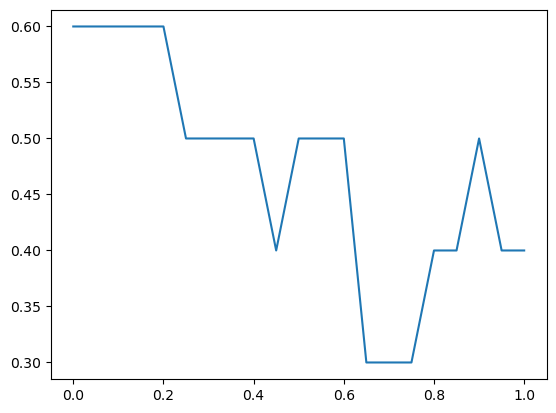

In [25]:
plt.plot(thresholds,scores)

## RAG Evaluation

In [27]:
prompt2_template = """
You are an expert evaluator for a Fitness RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [33]:
ground_truth[0]["question"]

{'id': 0, 'question': 'What is the starting position for doing push-ups?'}

In [53]:
answer_llm = ans = rag(ground_truth[0]["question"])

In [54]:
answer_llm

'The starting position for doing push-ups is a **high plank position with your hands under your shoulders**.'

In [56]:
prompt = prompt2_template.format(question=ground_truth[0]["question"], answer_llm=answer_llm)

In [57]:
print(prompt)

You are an expert evaluator for a Fitness RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What is the starting position for doing push-ups?
Generated Answer: The starting position for doing push-ups is a **high plank position with your hands under your shoulders**.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [59]:
print(llm(prompt))

```json
{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly and accurately addresses the question by describing the correct starting position for push-ups (high plank with hands under shoulders). No additional or irrelevant details are included, and the response is concise yet complete for the given query."
}
```


In [60]:
import json

In [ ]:
df_sample = df_question.sample(n=200, random_state=1)

In [ ]:
sample = df_sample.to_dict(orient='records')

In [ ]:
## Dont call function, very expensive function in terms o fmodel credit
evaluations = []

for record in tqdm(sample):
    question = record['question']
    answer_llm = rag(question)

    prompt = prompt2_template.format(question=ground_truth[0]["question"], answer_llm=answer_llm)
    evaluation = llm(prompt)
    evaluation = json.loads(evaluation)

    evaluations.append((record, answer_llm, evaluation))
    

In [ ]:
df_eval = pd.DataFrame(evaluations, columns=['record', 'answer', 'evaluation'])

df_eval['id'] = df_eval.record.apply(lambda d: d['id'])
df_eval['question'] = df_eval.record.apply(lambda d: d['question'])

df_eval['relevance'] = df_eval.evaluation.apply(lambda d: d['Relevance'])
df_eval['explanation'] = df_eval.evaluation.apply(lambda d: d['Explanation'])

del df_eval['record']
del df_eval['evaluation']

In [63]:
## Loading froma lready saved csv file

In [66]:
df_eval = pd.read_csv("data/rag-eval-gpt-4o-mini.csv")

In [67]:
df_eval

,answer,id,question,relevance,explanation
0,The primary muscle group activated during the ...,171,What is the primary muscle group activated dur...,RELEVANT,The generated answer accurately identifies the...
1,"Yes, jumping squats can be performed without a...",115,Can jumping squats be performed without any eq...,RELEVANT,The generated answer directly addresses the qu...
2,"To properly execute a Dumbbell Lateral Raise, ...",53,Can you explain the proper technique for execu...,RELEVANT,The generated answer provides a clear and deta...
3,To ensure your arms are fully extended during ...,198,How do I ensure my arms are fully extended dur...,RELEVANT,The generated answer provides detailed instruc...
4,The part of the body primarily engaged in Gobl...,19,What part of the body is primarily engaged in ...,RELEVANT,The generated answer accurately identifies tha...
...,...,...,...,...,...
195,The Pendlay Row specifically targets the upper...,83,What specific body parts does the Pendlay Row ...,PARTLY_RELEVANT,The generated answer identifies that the Pendl...
196,The TRX Push-Ups differ from traditional push-...,94,How does the TRX variation differ from traditi...,RELEVANT,The generated answer directly addresses the qu...
197,Beginners should approach the One-Legged Squat...,123,Can beginners safely attempt the One-Legged Sq...,RELEVANT,The generated answer directly addresses the qu...
198,To position your body while doing Flutter Kick...,76,How should I position my body while doing Flut...,RELEVANT,The generated answer directly addresses the qu...


In [73]:
df_eval.relevance.value_counts(normalize=True)

relevance
RELEVANT           0.835
PARTLY_RELEVANT    0.150
NON_RELEVANT       0.015
Name: proportion, dtype: float64